# Logistic Regression Model

https://www.drivendata.org/competitions/57/nepal-earthquake/page/136/

In [23]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, cross_validate, KFold, RandomizedSearchCV
import numpy as np

In [2]:
raw_train = pd.read_csv('Data/train_values.csv')
raw_label = pd.read_csv('Data/train_labels.csv')
df = pd.merge(raw_train, raw_label, how="left", on="building_id")
df.head()

,building_id,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,...,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other,damage_grade
0,802906,6,487,12198,2,30,6,5,t,r,...,0,0,0,0,0,0,0,0,0,3
1,28830,8,900,2812,2,10,8,7,o,r,...,0,0,0,0,0,0,0,0,0,2
2,94947,21,363,8973,2,10,5,5,t,r,...,0,0,0,0,0,0,0,0,0,3
3,590882,22,418,10694,2,10,6,5,t,r,...,0,0,0,0,0,0,0,0,0,2
4,201944,11,131,1488,3,30,8,9,t,r,...,0,0,0,0,0,0,0,0,0,3


In [3]:
# remove outliers
df = df[(df['age'] < 300) &
        (df['height_percentage'] < df['height_percentage'].quantile(0.9)) &
        (df['count_floors_pre_eq'] < df['count_floors_pre_eq'].quantile(0.9)) &
        (df['area_percentage'] < df['area_percentage'].quantile(0.9))
       ]

In [4]:
# check for NA values
df.isnull().sum()

building_id                               0
geo_level_1_id                            0
geo_level_2_id                            0
geo_level_3_id                            0
count_floors_pre_eq                       0
age                                       0
area_percentage                           0
height_percentage                         0
land_surface_condition                    0
foundation_type                           0
roof_type                                 0
ground_floor_type                         0
other_floor_type                          0
position                                  0
plan_configuration                        0
has_superstructure_adobe_mud              0
has_superstructure_mud_mortar_stone       0
has_superstructure_stone_flag             0
has_superstructure_cement_mortar_stone    0
has_superstructure_mud_mortar_brick       0
has_superstructure_cement_mortar_brick    0
has_superstructure_timber                 0
has_superstructure_bamboo       

## Create Pipeline

In [5]:
# # define variables for ColumnTransformer
# numerical = ['count_floors_pre_eq', 'age', 'area_percentage', 'height_percentage', 'count_families']

# categorical = ['land_surface_condition', 'foundation_type', 'roof_type', 'ground_floor_type', 'other_floor_type', 'position', 'plan_configuration', 'legal_ownership_status']

# binary = ['has_superstructure_adobe_mud', 'has_superstructure_mud_mortar_stone', 'has_superstructure_stone_flag', 'has_superstructure_cement_mortar_stone', 'has_superstructure_mud_mortar_brick', 'has_superstructure_cement_mortar_brick', 'has_superstructure_timber', 'has_superstructure_bamboo', 'has_superstructure_rc_non_engineered', 'has_superstructure_rc_engineered', 'has_superstructure_other', 'has_secondary_use', 'has_secondary_use_agriculture', 'has_secondary_use_hotel', 'has_secondary_use_rental', 'has_secondary_use_institution', 'has_secondary_use_school', 'has_secondary_use_industry', 'has_secondary_use_health_post', 'has_secondary_use_gov_office', 'has_secondary_use_use_police', 'has_secondary_use_other', 'geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id']

In [6]:
numerical = ['count_families', 'count_floors_pre_eq', 'height_percentage', 'area_percentage', 'age']

categorical = ['other_floor_type', 'ground_floor_type', 'roof_type', 'foundation_type']

binary = ['has_superstructure_timber', 'has_superstructure_cement_mortar_brick', 'has_superstructure_mud_mortar_stone', 'geo_level_3_id', 'geo_level_2_id', 'geo_level_1_id']

In [7]:
numeric_transformer = Pipeline(
    steps=[("scaler", StandardScaler())]
)

categorical_transformer = Pipeline(
    steps=[("onehot", OneHotEncoder(handle_unknown="ignore"))]
)

binary_transformer = Pipeline(
    steps=[("ordinal", OneHotEncoder(handle_unknown="ignore"))]
)

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numerical),
        ("cat", categorical_transformer, categorical),
        ("binary", binary_transformer, binary)
    ]
)

In [8]:
train = df[numerical + categorical + binary]
label = df['damage_grade']

In [9]:
X_train, X_test, y_train, y_test = train_test_split(train, label, test_size=0.2, shuffle=True)

In [10]:
pipeline = preprocessor.fit(X_train)
train_x, test_x = pipeline.transform(X_train), pipeline.transform(X_test)

## Model Fitting and Cross Validation

In [17]:
kf = KFold(n_splits=5)

for train_index, test_index in kf.split(train_x):
    X_train_cv, X_test_cv = train_x[train_index], train_x[test_index]
    y_train_cv, y_test_cv = y_train.to_numpy()[train_index], y_train.to_numpy()[test_index]

    clf = LogisticRegression(solver="lbfgs", max_iter=100000,
                             multi_class = "multinomial")
    clf.fit(X_train_cv, y_train_cv)

    predict = clf.predict(X_test_cv)
    print(accuracy_score(y_test_cv, predict))
    print(confusion_matrix(y_test_cv, predict))
    print("\n")

0.7359486038331778
[[ 1286  1457    63]
 [  617 13815  1734]
 [   91  3395  5404]]


0.7388557892470031
[[ 1239  1352    61]
 [  596 14008  1794]
 [   89  3384  5339]]


0.7384250951116216
[[ 1347  1337    69]
 [  620 13765  1879]
 [   76  3307  5462]]


0.7405333620473062
[[ 1273  1354    55]
 [  625 13936  1808]
 [   79  3308  5423]]


0.740605146979649
[[ 1261  1413    69]
 [  634 13986  1705]
 [   64  3342  5387]]




## Randomized CV Search

### $l_2$ Penalty

In [11]:
# hyperparameters
param_grid = {
    'C': [0.01, 0.1, 0.5, 1, 5, 10],
    'solver': ['newton-cg', 'sag', 'saga', 'lbfgs']
}

# model
logistic = LogisticRegression(multi_class = "multinomial", max_iter=100000,
                             penalty="l2")

# cross validation
# cv = KFold(n_splits=5, shuffle=True)

In [12]:
search = RandomizedSearchCV(estimator=logistic, param_distributions=param_grid, n_iter=10, scoring="accuracy", n_jobs=-1)
search.fit(train_x, y_train)
print('Best Score: %s' % search.best_score_)
print('Best Hyperparameters: %s' % search.best_params_)

Best Score: 0.7393114756793915
Best Hyperparameters: {'solver': 'newton-cg', 'C': 0.5}


In [13]:
svc_prediction = search.predict(test_x)
print(f"Accuracy score: {accuracy_score(y_test, svc_prediction)}")

Accuracy score: 0.7468630660120021


In [14]:
print(confusion_matrix(y_test, svc_prediction))

[[ 1558  1712    86]
 [  680 17750  2048]
 [   92  4198  6703]]


In [85]:
np.sum(confusion_matrix(y_test, svc_prediction))

34827

In [83]:
100/np.sum(rf_cm)

0.001534895857316081

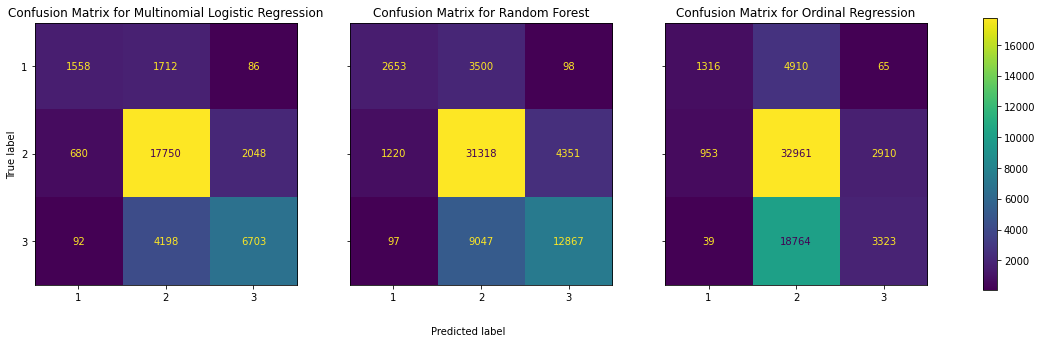

In [77]:
f, axes = plt.subplots(1, 3, figsize=(20, 5), sharey='row')
classes = np.array([1, 2, 3])

# multinomial logistic regression
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, svc_prediction),
                              display_labels=search.classes_,)
disp.plot(ax=axes[0])
disp.ax_.set_title("Confusion Matrix for Multinomial Logistic Regression")
disp.im_.colorbar.remove()
disp.ax_.set_xlabel('')

# random forest
rf_cm = np.array([[2653, 3500, 98], [1220, 31318, 4351], [97, 9047, 12867]])
disp_rf = ConfusionMatrixDisplay(confusion_matrix=rf_cm,
                                  display_labels=classes)
disp_rf.plot(ax=axes[1])
disp_rf.ax_.set_title("Confusion Matrix for Random Forest")
disp_rf.im_.colorbar.remove()
disp_rf.ax_.set_xlabel('')
disp_rf.ax_.set_ylabel('')

# ordinal regression
or_reg = np.array([[1316, 4910, 65], [953, 32961, 2910], [39, 18764, 3323]])
classes = np.array([1, 2, 3])
disp_or = ConfusionMatrixDisplay(confusion_matrix=or_reg,
                              display_labels=classes)
disp_or.plot(ax=axes[2])
disp_or.ax_.set_title("Confusion Matrix for Ordinal Regression")
disp_or.im_.colorbar.remove()
disp_or.ax_.set_xlabel('')
disp_or.ax_.set_ylabel('')

f.text(0.4, 0, 'Predicted label', ha='left')
f.colorbar(disp.im_, ax=axes)

plt.savefig("confusion_matrix.jpeg", bbox_inches='tight')
plt.show()

### $l_1$ Penalty

In [16]:
param_grid_l1 = {
    'C': [0.01, 0.1, 0.5, 1, 5, 10],
    'solver': ['liblinear', 'saga']
}

logistic_l1 = LogisticRegression(multi_class = "multinomial", max_iter=100000,
                                 penalty="l1")

In [17]:
search_l1 = RandomizedSearchCV(estimator=logistic_l1, param_distributions=param_grid_l1, n_iter=3, scoring="accuracy", n_jobs=-1)
search_l1.fit(train_x, y_train)
print('Best Score: %s' % search_l1.best_score_)
print('Best Hyperparameters: %s' % search_l1.best_params_)

KeyboardInterrupt: 

In [ ]:
svc_prediction_l1 = search_l1.predict(test_x)
print(f"Accuracy score: {accuracy_score(y_test, svc_prediction_l1)}")